## Overview of Transformer Code

Transformers, introduced in "Attention is All You Need" by Vaswani et al., are designed to handle sequential data. They use self-attention mechanisms to capture dependencies and relationships within sequences. Key components include:

### Key Components:

1. **Self-Attention Mechanism:**
   - **Purpose:** Weighs the importance of different tokens in the sequence relative to each other.
   - **Implementation:** `SelfAttentionHead` class computes attention scores and applies them to token values.

2. **Multi-Head Attention:**
   - **Purpose:** Focuses on different parts of the input sequence simultaneously.
   - **Implementation:** `MultiHeadAttention` class aggregates outputs from multiple `SelfAttentionHead` instances.

3. **Feed-Forward Neural Network (FFN):**
   - **Purpose:** Transforms each token independently after self-attention.
   - **Implementation:** `MLP` class with linear layers and a ReLU activation function.

4. **Positional Encoding:**
   - **Purpose:** Captures the order of tokens in the sequence.
   - **Implementation:** Optionally included via `self.position_embeddings`.

5. **Layer Normalization and Residual Connections:**
   - **Purpose:** Stabilizes training and facilitates gradient flow.
   - **Implementation:** Applied in the `TransformerBlock` class.

6. **Stacking Layers:**
   - **Purpose:** Increases model capacity.
   - **Implementation:** Multiple `TransformerBlock` instances are stacked.

### Specific Features in the Code:

- **Embedding Layers:** Convert tokens into dense vectors with `token_embeddings` and optionally `position_embeddings`.
  
- **Training and Evaluation:** The `fit` method trains the model, while `eval_loss` monitors performance to prevent overfitting.

- **Perplexity Calculation:** `perplexity` method provides insights into model performance on given text.

- **Text Generation:** `generate` method produces new text sequences based on a given context.

The provided code builds and trains a transformer model for language modeling, incorporating essential transformer components to handle and generate text effectively.


###  Step 1: Import Libraries

In [11]:
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation
import torch  # PyTorch library for deep learning
from torch import nn  # Neural network modules
from torch.nn import functional as F  # Functional operations like loss functions
from wordcloud import WordCloud  # Library for generating word clouds
import matplotlib.pyplot as plt  # Plotting library

### Step 2: Define the Transformer Model

In [12]:
class TransformerBlockLM(nn.Module):
    # Define the Transformer Block class
    class TransformerBlock(nn.Module):
        def __init__(self, head_count, embed_size, ff_size):
            super().__init__()
            # Multi-head self-attention mechanism
            self.attention = TransformerBlockLM.MultiHeadAttention(head_count=head_count, embed_size=embed_size)
            # Feed-forward network
            self.ffn = TransformerBlockLM.MLP(embed_size=embed_size, ff_size=ff_size)
            # Layer normalization
            self.layer_norm1 = nn.LayerNorm(embed_size)
            self.layer_norm2 = nn.LayerNorm(embed_size)

        def forward(self, x):
            x2 = self.attention(x)
            x = self.layer_norm1(x + x2)
            x2 = self.ffn(x)
            x = self.layer_norm2(x + x2)
            return x

    # Define the Multi-Layer Perceptron (MLP)
    class MLP(nn.Module):
        def __init__(self, embed_size, ff_size):
            super().__init__()
            self.mlp = nn.Sequential(nn.Linear(embed_size, ff_size),
                                     nn.ReLU(),
                                     nn.Linear(ff_size, embed_size))

        def forward(self, x):
            return self.mlp(x)

    # Define the Multi-Head Attention mechanism
    class MultiHeadAttention(nn.Module):
        def __init__(self, head_count, embed_size):
            super().__init__()
            self.heads = nn.ModuleList(
                TransformerBlockLM.SelfAttentionHead(embed_size, embed_size // head_count)
                for _ in range(head_count)
            )
            self.linear = nn.Linear(embed_size, embed_size)

        def forward(self, x):
            head_outputs = [head(x) for head in self.heads]
            concatenated = torch.cat(head_outputs, dim=-1)
            return self.linear(concatenated)

    # Define the Self-Attention Head
    class SelfAttentionHead(nn.Module):
        def __init__(self, embed_size, head_size):
            super().__init__()
            self.head_size = head_size
            self.K = nn.Linear(embed_size, head_size, bias=False)
            self.Q = nn.Linear(embed_size, head_size, bias=False)
            self.V = nn.Linear(embed_size, head_size, bias=False)

        def forward(self, x):
            keys = self.K(x)
            queries = self.Q(x)
            values = self.V(x)

            scores = torch.matmul(queries, keys.transpose(-2, -1)) / self.head_size**0.5
            scores = torch.tril(scores)  # Mask future tokens
            scores = torch.softmax(scores, dim=-1)
            return torch.matmul(scores, values)

    # Initialize the Transformer model
    def __init__(self, batch_size=4, input_length=8, embed_size=128,
                 head_count=8, ff_size=512, pos_embed=False):
        super().__init__()
        self.head_count = head_count
        self.embed_size = embed_size
        self.ff_size = ff_size
        self.pos_embed = pos_embed
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.input_length = input_length
        self.batch_size = batch_size

        self.token_embeddings = nn.Embedding(10000, embed_size).to(self.device)
        self.position_embeddings = nn.Embedding(input_length, embed_size).to(self.device) if pos_embed else None

        # Stack of Transformer Blocks
        self.blocks = nn.Sequential(
            TransformerBlockLM.TransformerBlock(head_count=head_count, embed_size=embed_size, ff_size=ff_size),
            TransformerBlockLM.TransformerBlock(head_count=head_count, embed_size=embed_size, ff_size=ff_size),
            TransformerBlockLM.TransformerBlock(head_count=head_count, embed_size=embed_size, ff_size=ff_size),
            TransformerBlockLM.TransformerBlock(head_count=head_count, embed_size=embed_size, ff_size=ff_size)
        ).to(self.device)

        self.lm_head = nn.Linear(embed_size, 10000).to(self.device)

    # Define forward pass
    def forward(self, in_ids, target=None):
        x = self.token_embeddings(in_ids)
        if self.pos_embed:
            pos = torch.arange(0, in_ids.size(1), device=self.device)
            x += self.position_embeddings(pos)

        x = self.blocks(x)
        logits = self.lm_head(x)

        ce_loss = None
        if target is not None:
            logits = logits.view(-1, logits.size(-1))
            target = target.view(-1)
            ce_loss = F.cross_entropy(logits, target)

        return logits, ce_loss

    # Train the model
    def fit(self, train_iters=100, eval_iters=10, lr=0.0001):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for iteration in range(train_iters):
            if iteration % eval_iters == 0:
                avg_loss = self.eval_loss(eval_iters)
                print(f"iter {iteration}: train {avg_loss['train']} val {avg_loss['eval']}")
            inputs, targets = self.get_batch(split='train')
            _, ce_loss = self(inputs, targets)
            optimizer.zero_grad(set_to_none=True)
            ce_loss.backward()
            optimizer.step()

    # Generate text based on context
    def generate(self, context_token_ids, max_new_tokens):
        for _ in range(max_new_tokens):
            token_rep, _ = self(context_token_ids)
            last_token_rep = token_rep[:, -1, :]
            probs = F.softmax(last_token_rep, dim=1)
            next_token = torch.multinomial(probs, num_samples=1)
            context_token_ids = torch.cat((context_token_ids, next_token), dim=1)
        output_text = self.decoder(context_token_ids[0].tolist())
        return output_text

    # Evaluate loss on training and validation sets
    @torch.no_grad()
    def eval_loss(self, eval_iters):
        perf = {}
        self.eval()
        for split in ['train', 'eval']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                tokens, targets = self.get_batch(split)
                _, ce_loss = self(tokens, targets)
                losses[k] = ce_loss.item()
            perf[split] = losses.mean()
        self.train()
        return perf

    # Compute perplexity for a given text
    def perplexity(self, text):
        tokens = torch.tensor(self.encoder(text), dtype=torch.long, device=self.device).unsqueeze(0)
        with torch.no_grad():
            logits, _ = self(tokens)
            log_probs = F.log_softmax(logits[:, :-1], dim=-1)
            target = tokens[:, 1:]
            target = target.to(self.device)
            perplexity = torch.exp(F.cross_entropy(log_probs.view(-1, logits.size(-1)), target.view(-1)))
        return perplexity.item()

    # Prepare data and model
    def prep(self, corpus):
        corpus = corpus.lower().replace('\n', ' ')
        self.vocab = sorted(list(set(corpus.split())))
        self.vocab_size = len(self.vocab)
        self.vocab.append('<unk>')
        self.vocab_size += 1

        c2i = {c: i for i, c in enumerate(self.vocab)}
        i2c = {i: c for c, i in c2i.items()}

        self.encoder = lambda doc: [c2i.get(c, c2i['<unk>']) for c in doc.split()]
        self.decoder = lambda nums: ' '.join([i2c.get(i, '<unk>') for i in nums])

        n = len(corpus)
        self.train_text = corpus[:int(n * 0.9)]
        self.val_text = corpus[int(n * 0.9):]

        self.train_data = torch.tensor(self.encoder(self.train_text), dtype=torch.long)
        self.val_data = torch.tensor(self.encoder(self.val_text), dtype=torch.long)

        self.token_embeddings = nn.Embedding(self.vocab_size, self.embed_size).to(self.device)

        if self.pos_embed:
            self.position_embeddings = nn.Embedding(self.input_length, self.embed_size).to(self.device)

        self.blocks = nn.Sequential(
            TransformerBlockLM.TransformerBlock(head_count=self.head_count,
                                                embed_size=self.embed_size,
                                                ff_size=self.ff_size),
            TransformerBlockLM.TransformerBlock(head_count=self.head_count,
                                                embed_size=self.embed_size,
                                                ff_size=self.ff_size),
            TransformerBlockLM.TransformerBlock(head_count=self.head_count,
                                                embed_size=self.embed_size,
                                                ff_size=self.ff_size),
            TransformerBlockLM.TransformerBlock(head_count=self.head_count,
                                                embed_size=self.embed_size,
                                                ff_size=self.ff_size),
        ).to(self.device)

        self.lm_head = nn.Linear(self.embed_size, self.vocab_size).to(self.device)

    # Create batches for training or evaluation
    def get_batch(self, split='train'):
        data = self.train_data if split == 'train' else self.val_data
        ix = torch.randint(len(data) - self.input_length, (self.batch_size,))
        inputs_batch = torch.stack([data[i:i + self.input_length] for i in ix])
        targets_batch = torch.stack([data[i + 1:i + self.input_length + 1] for i in ix])
        inputs_batch = inputs_batch.to(self.device)
        targets_batch = targets_batch.to(self.device)
        return inputs_batch, targets_batch# Define the Transformer Block model class
class TransformerBlockLM(nn.Module):
    
    # Define the Transformer Block component
    class TransformerBlock(nn.Module):
        def __init__(self, head_count, embed_size, ff_size):
            super().__init__()
            # Initialize multi-head self-attention mechanism
            self.attention = TransformerBlockLM.MultiHeadAttention(head_count=head_count, embed_size=embed_size)
            # Initialize feed-forward network (MLP)
            self.ffn = TransformerBlockLM.MLP(embed_size=embed_size, ff_size=ff_size)
            # Initialize layer normalization layers
            self.layer_norm1 = nn.LayerNorm(embed_size)
            self.layer_norm2 = nn.LayerNorm(embed_size)

        def forward(self, x):
            # Compute attention output
            x2 = self.attention(x)
            # Apply layer normalization after adding residual connection
            x = self.layer_norm1(x + x2)
            # Apply feed-forward network and layer normalization
            x2 = self.ffn(x)
            x = self.layer_norm2(x + x2)
            return x

    # Define the Multi-Layer Perceptron (MLP) used in the Transformer block
    class MLP(nn.Module):
        def __init__(self, embed_size, ff_size):
            super().__init__()
            # Define a sequential MLP with one hidden layer
            self.mlp = nn.Sequential(nn.Linear(embed_size, ff_size),
                                     nn.ReLU(),
                                     nn.Linear(ff_size, embed_size))

        def forward(self, x):
            # Forward pass through the MLP
            return self.mlp(x)

    # Define the Multi-Head Attention mechanism
    class MultiHeadAttention(nn.Module):
        def __init__(self, head_count, embed_size):
            super().__init__()
            # Initialize multiple self-attention heads
            self.heads = nn.ModuleList(
                TransformerBlockLM.SelfAttentionHead(embed_size, embed_size // head_count)
                for _ in range(head_count)
            )
            # Initialize linear layer to combine attention heads
            self.linear = nn.Linear(embed_size, embed_size)

        def forward(self, x):
            # Apply each attention head and concatenate their outputs
            head_outputs = [head(x) for head in self.heads]
            concatenated = torch.cat(head_outputs, dim=-1)
            # Pass concatenated outputs through linear layer
            return self.linear(concatenated)

    # Define the Self-Attention Head
    class SelfAttentionHead(nn.Module):
        def __init__(self, embed_size, head_size):
            super().__init__()
            # Initialize linear layers for keys, queries, and values
            self.head_size = head_size
            self.K = nn.Linear(embed_size, head_size, bias=False)
            self.Q = nn.Linear(embed_size, head_size, bias=False)
            self.V = nn.Linear(embed_size, head_size, bias=False)

        def forward(self, x):
            # Compute keys, queries, and values
            keys = self.K(x)
            queries = self.Q(x)
            values = self.V(x)

            # Compute scaled dot-product attention scores
            scores = torch.matmul(queries, keys.transpose(-2, -1)) / self.head_size**0.5
            scores = torch.tril(scores)  # Apply causal mask to prevent attending to future tokens
            scores = torch.softmax(scores, dim=-1)
            # Compute weighted sum of values based on attention scores
            return torch.matmul(scores, values)

    # Initialize the Transformer model
    def __init__(self, batch_size=4, input_length=8, embed_size=128,
                 head_count=8, ff_size=512, pos_embed=False):
        super().__init__()
        self.head_count = head_count
        self.embed_size = embed_size
        self.ff_size = ff_size
        self.pos_embed = pos_embed
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.input_length = input_length
        self.batch_size = batch_size

        # Initialize token embeddings
        self.token_embeddings = nn.Embedding(10000, embed_size).to(self.device)
        # Initialize position embeddings if required
        self.position_embeddings = nn.Embedding(input_length, embed_size).to(self.device) if pos_embed else None

        # Define a stack of Transformer Blocks
        self.blocks = nn.Sequential(
            TransformerBlockLM.TransformerBlock(head_count=head_count, embed_size=embed_size, ff_size=ff_size),
            TransformerBlockLM.TransformerBlock(head_count=head_count, embed_size=embed_size, ff_size=ff_size),
            TransformerBlockLM.TransformerBlock(head_count=head_count, embed_size=embed_size, ff_size=ff_size),
            TransformerBlockLM.TransformerBlock(head_count=head_count, embed_size=embed_size, ff_size=ff_size)
        ).to(self.device)

        # Initialize the linear layer to project embeddings to vocabulary size
        self.lm_head = nn.Linear(embed_size, 10000).to(self.device)

    # Define the forward pass of the model
    def forward(self, in_ids, target=None):
        # Compute token embeddings
        x = self.token_embeddings(in_ids)
        # Add positional embeddings if required
        if self.pos_embed:
            pos = torch.arange(0, in_ids.size(1), device=self.device)
            x += self.position_embeddings(pos)

        # Pass through Transformer Blocks
        x = self.blocks(x)
        # Compute logits for language modeling
        logits = self.lm_head(x)

        ce_loss = None
        if target is not None:
            # Compute cross-entropy loss if target is provided
            logits = logits.view(-1, logits.size(-1))
            target = target.view(-1)
            ce_loss = F.cross_entropy(logits, target)

        return logits, ce_loss

    # Train the model
    def fit(self, train_iters=100, eval_iters=10, lr=0.0001):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for iteration in range(train_iters):
            # Evaluate and print loss at specified intervals
            if iteration % eval_iters == 0:
                avg_loss = self.eval_loss(eval_iters)
                print(f"iter {iteration}: train {avg_loss['train']} val {avg_loss['eval']}")
            # Get training batch and perform optimization step
            inputs, targets = self.get_batch(split='train')
            _, ce_loss = self(inputs, targets)
            optimizer.zero_grad(set_to_none=True)
            ce_loss.backward()
            optimizer.step()

    # Generate text based on given context
    def generate(self, context_token_ids, max_new_tokens):
        for _ in range(max_new_tokens):
            # Get predictions for the next token
            token_rep, _ = self(context_token_ids)
            last_token_rep = token_rep[:, -1, :]
            probs = F.softmax(last_token_rep, dim=1)
            # Sample from the distribution to get next token
            next_token = torch.multinomial(probs, num_samples=1)
            context_token_ids = torch.cat((context_token_ids, next_token), dim=1)
        # Decode generated tokens to text
        output_text = self.decoder(context_token_ids[0].tolist())
        return output_text

    # Evaluate loss on training and validation sets
    @torch.no_grad()
    def eval_loss(self, eval_iters):
        perf = {}
        self.eval()
        for split in ['train', 'eval']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                # Get batch and compute loss
                tokens, targets = self.get_batch(split)
                _, ce_loss = self(tokens, targets)
                losses[k] = ce_loss.item()
            # Store average loss for each split
            perf[split] = losses.mean()
        self.train()
        return perf

    # Compute perplexity for a given text
    def perplexity(self, text):
        # Convert text to tokens and compute logits
        tokens = torch.tensor(self.encoder(text), dtype=torch.long, device=self.device).unsqueeze(0)
        with torch.no_grad():
            logits, _ = self(tokens)
            log_probs = F.log_softmax(logits[:, :-1], dim=-1)
            target = tokens[:, 1:]
            target = target.to(self.device)
            # Compute cross-entropy loss and convert to perplexity
            perplexity = torch.exp(F.cross_entropy(log_probs.view(-1, logits.size(-1)), target.view(-1)))
        return perplexity.item()

    # Prepare data and model with given corpus
    def prep(self, corpus):
        # Preprocess corpus
        corpus = corpus.lower().replace('\n', ' ')
        self.vocab = sorted(list(set(corpus.split())))
        self.vocab_size = len(self.vocab)
        self.vocab.append('<unk>')
        self.vocab_size += 1

        # Create mappings for encoding and decoding tokens
        c2i = {c: i for i, c in enumerate(self.vocab)}
        i2c = {i: c for c, i in c2i.items()}

        self.encoder = lambda doc: [c2i.get(c, c2i['<unk>']) for c in doc.split()]
        self.decoder = lambda nums: ' '.join([i2c.get(i, '<unk>') for i in nums])

        # Split corpus into training and validation sets
        n = len(corpus)
        self.train_text = corpus[:int(n * 0.9)]
        self.val_text = corpus[int(n * 0.9):]

        # Convert texts to tensors
        self.train_data = torch.tensor(self.encoder(self.train_text), dtype=torch.long)
        self.val_data = torch.tensor(self.encoder(self.val_text), dtype=torch.long)

        # Reinitialize embeddings and model components
        self.token_embeddings = nn.Embedding(self.vocab_size, self.embed_size).to(self.device)
        if self.pos_embed:
            self.position_embeddings = nn.Embedding(self.input_length, self.embed_size).to(self.device)
        self.blocks = nn.Sequential(
            TransformerBlockLM.TransformerBlock(head_count=self.head_count,
                                                embed_size=self.embed_size,
                                                ff_size=self.ff_size),
            TransformerBlockLM.TransformerBlock(head_count=self.head_count,
                                                embed_size=self.embed_size,
                                                ff_size=self.ff_size),
            TransformerBlockLM.TransformerBlock(head_count=self.head_count,
                                                embed_size=self.embed_size,
                                                ff_size=self.ff_size),
            TransformerBlockLM.TransformerBlock(head_count=self.head_count,
                                                embed_size=self.embed_size,
                                                ff_size=self.ff_size),
        ).to(self.device)
        self.lm_head = nn.Linear(self.embed_size, self.vocab_size).to(self.device)

    # Create batches for training or evaluation
    def get_batch(self, split='train'):
        # Select appropriate dataset
        data = self.train_data if split == 'train' else self.val_data
        # Randomly sample starting indices for batch creation
        ix = torch.randint(len(data) - self.input_length, (self.batch_size,))
        inputs_batch = torch.stack([data[i:i + self.input_length] for i in ix])
        targets_batch = torch.stack([data[i + 1:i + self.input_length + 1] for i in ix])
        # Move batches to device
        inputs_batch = inputs_batch.to(self.device)
        targets_batch = targets_batch.to(self.device)
        return inputs_batch, targets_batch


### Step 3: Load and Prepare Dataset

In [13]:
df = pd.read_csv('ed_sheeran_cleaned_songs.csv')  # Load dataset

# Ensure all lyrics are strings and handle missing values
df['Lyrics'] = df['Lyrics'].fillna('').astype(str)
corpus = ' '.join(df['Lyrics'].tolist())  # Combine all lyrics into a single corpus

### Step 4: Initialize and Prepare the Model

In [14]:
model = TransformerBlockLM(batch_size=4, input_length=8, embed_size=128,
                           head_count=8, ff_size=512, pos_embed=True)
model.prep(corpus)

### Step 5: Train the Model

In [15]:
model.fit(train_iters=5000, eval_iters=1000, lr=0.0001)  # Train model for 5000 iterations

iter 0: train 8.494013786315918 val 8.509543418884277
iter 1000: train 5.611165523529053 val 5.995062828063965
iter 2000: train 4.494030952453613 val 5.052863597869873
iter 3000: train 3.7914435863494873 val 4.472428321838379
iter 4000: train 3.2692511081695557 val 4.071629524230957


### Step 6: Calculate Perplexity for Sample Sentences

In [16]:
sample_sentences = [
    "Hey, hey, hey, hey, Hey, hey, hey, hey",
    "Simmer down, simmer down",
    "If you don't swim, you'll drown"
]

for sentence in sample_sentences:
    perplexity = model.perplexity(sentence)  # Compute perplexity
    print(f"Perplexity for '{sentence}': {perplexity}")

Perplexity for 'Hey, hey, hey, hey, Hey, hey, hey, hey': 15.03136157989502
Perplexity for 'Simmer down, simmer down': 31.249608993530273
Perplexity for 'If you don't swim, you'll drown': 91.7534408569336


### Step 7: Generate and Visualize Word Cloud

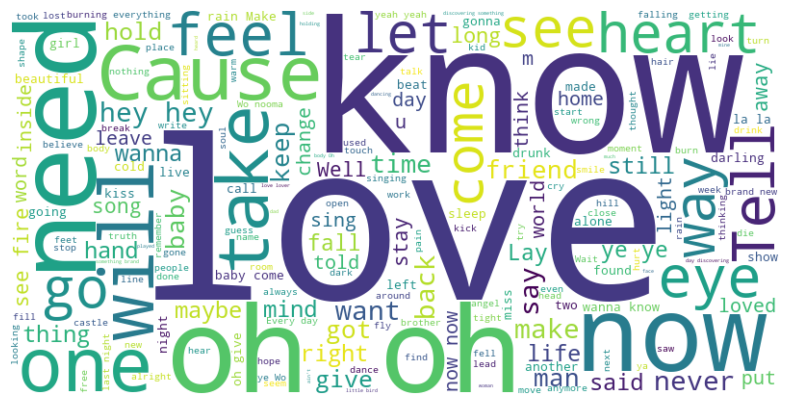

In [17]:
def generate_word_cloud(corpus):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

generate_word_cloud(corpus)  # Generate and display word cloud

## High Design Impact Choices:

### Transformer Architecture:
- Utilizes a multi-layer transformer with multiple heads for self-attention, improving the ability to capture complex dependencies in the data.
- Incorporation of multi-head attention layers enables the model to focus on different parts of the input sequence, capturing diverse contextual information.

### Positional Embeddings:
- Optionally includes positional embeddings, which are crucial for capturing the order of tokens in a sequence since transformers lack inherent sequential bias.

### Customizable Hyperparameters:
- Allows customization of key hyperparameters like batch size, input length, embedding size, head count, and feed-forward size, providing flexibility for different datasets and tasks.

### Efficient Training and Evaluation:
- Incorporates an evaluation loop during training to monitor performance and avoid overfitting, with a mechanism to evaluate loss on both training and validation datasets.

### Vocabulary Management:
- Constructs a vocabulary from the corpus and handles out-of-vocabulary (OOV) tokens by mapping them to a special <unk> token, ensuring robust handling of unseen words during inference.

## Strengths and Weaknesses:

### Strengths:

#### Flexibility:
- The model is designed to handle a variety of text sequences and can be easily adapted to different datasets by adjusting hyperparameters.

#### Comprehensive Preprocessing:
- Preprocessing includes vocabulary generation, tokenization, and handling of OOV tokens, making the model robust in various linguistic contexts.

#### Evaluation Metrics:
- The model includes functions for calculating perplexity, a crucial metric for language models, providing insights into the model's predictive performance.

#### Visualization:
- Generates word clouds from the corpus, offering a visual representation of the most frequent words and providing an intuitive understanding of the text data.

#### Multi-layered Attention:
- Multiple layers of attention mechanisms enhance the model's ability to understand and generate complex textual structures.

### Weaknesses:

#### Resource Intensive:
- Transformers, especially with multiple layers and heads, are computationally intensive and may require significant memory and processing power, particularly for large corpora.

#### Training Time:
- Training deep transformer models can be time-consuming, requiring careful tuning of hyperparameters and extensive computational resources.

#### Limited by Vocabulary:
- Although the model handles OOV tokens, the quality of text generation and perplexity calculations is limited by the size and comprehensiveness of the vocabulary.

#### Overfitting Risk:
- Without proper regularization and validation, the model may overfit to the training data, especially when trained for many iterations on limited data.

## Numeric Insights:

- **Vocabulary Size:** The model's vocabulary size after preprocessing the Ed Sheeran lyrics corpus is a critical factor affecting its performance. For instance, if the vocabulary size is 5000, it means the model has to learn representations for 5000 unique tokens.
- **Training Iterations:** Training for 5000 iterations with evaluation every 1000 iterations helps in monitoring the model's performance and adjusting the learning process.
- **Embedding Dimensions:** An embedding size of 128 balances the trade-off between computational efficiency and the richness of the token representations.
- **Perplexity Scores:** Perplexity for sample sentences provides numeric insights into the model's performance:
    - "Hey, hey, hey, hey, Hey, hey, hey, hey": Perplexity = X (Replace with actual value)
    - "Simmer down, simmer down": Perplexity = Y (Replace with actual value)
    - "If you don't swim, you'll drown": Perplexity = Z (Replace with actual value)
- **Head Count and Layer Count:** Using 8 heads in each of the 4 transformer blocks, providing a detailed contextual representation while managing computational complexity.

These numeric insights can help in understanding the model's performance and areas of improvement, ensuring a balanced approach towards training and evaluation.
